In [ ]:
#| default_exp ham

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML

In [ ]:
#| hide
warnings.simplefilter('ignore')
np.set_printoptions(precision=3)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# HAM

> Assembling layers and synapses into a single system governed by an energy function

In [ ]:
#|echo:false
HTML("""
<img src="https://raw.githubusercontent.com/bhoov/hamux/main/assets/fig1.png" alt="HAMUX Overview" width="700"/>
""")

We have now provided the two primary components: `layers` and `synapses`. This module assembles those together into a single network that is governed by an energy function

In [ ]:
#| export 
import jax
import jax.numpy as jnp
from typing import *
import treex as tx
from hamux.layers import Layer
from hamux.synapses import Synapse
import jax.tree_util as jtu
from hamux.utils import pytree_save, pytree_load, to_pickleable, align_with_state_dict
import pickle
import functools as ft
from fastcore.utils import *
from abc import ABC, abstractmethod, abstractproperty
import hypernetx as hnetx

## HAM Basics

We connect `layers` and `synapses` in a [hypergraph](https://en.wikipedia.org/wiki/Hypergraph) to describe the energy function. A hypergraph is a generalization of the familiar graph in that edges (synapses) can connect multiple nodes (layers). This graph -- complete with the operations of the synapses and the activation behavior of the layers -- fully defines the energy function for a given collection of neuron states.

In [ ]:
#|export
class HAM(tx.Module):
    layers: List[Layer]
    synapses: List[Synapse]
    connections: List[Tuple[Tuple, int]]

    def __init__(self, layers, synapses, connections):
        self.layers = layers
        self.synapses = synapses
        self.connections = connections

    @property
    def n_layers(self): return len(self.layers)
    @property
    def n_synapses(self): return len(self.synapses)
    @property
    def n_connections(self): return len(self.connections)
    @property
    def layer_taus(self): return [layer.tau for layer in self.layers]
    def alphas(self, dt): return [dt / tau for tau in self.layer_taus]

In [ ]:
#|export
@patch
def activations(self:HAM, 
                xs:jnp.ndarray): # Collection of states for each layer
    """Turn a collection of states into a collection of activations"""
    gs = [self.layers[i].g(xs[i]) for i in range(len(xs))]
    return gs

In [ ]:
#|export
@patch
def layer_energy(self:HAM,
                 xs:jnp.ndarray): # Collection of states for each layer
    """The total contribution of the layers' contribution to the energy of the HAM"""
    energies = jnp.stack([self.layers[i].energy(x) for i, x in enumerate(xs)])
    return jnp.sum(energies)

@patch
def synapse_energy(self:HAM,
                   gs:jnp.ndarray): # Collection of activations of each layer
    """The total contribution of the synapses' contribution to the energy of the HAM.
    
    A function of the activations `gs` rather than the states `xs`
    """
    def get_energy(lset, k):
        mygs = [gs[i] for i in lset]
        synapse = self.synapses[k]
        return synapse.energy(*mygs)
    energies = jnp.stack([get_energy(lset, k) for lset, k in self.connections])
    return jnp.sum(energies)

@patch
def energy(self:HAM,
           xs:jnp.ndarray): # Collection of states for each layer
    """The complete energy of the HAM"""
    gs = self.activations(xs)
    energy = self.layer_energy(xs) + self.synapse_energy(gs)
    return energy

As is typical for JAX frameworks, the parameters of HAMs need to be initialized. Unlike other machine learning libraries, the *states* of each *layer* -- that is, the dynamical variables of our system -- also need to be initialized. The notation $\mathbf{x}$ indicates the collection of all states from each layer, and $x^\alpha$ indicates that we are referring to the state of layer at index $\alpha$ in our collection. 

We provide this functionality with the following helper functions:

In [ ]:
#| export
@patch
def init_states(self:HAM, 
                bs=None, # Batch size of the states to initialize, if needed
                rng=None): # RNG seed for random initialization of the states, if non-zero initializations are desired
    """Initialize the states of every layer in the network"""
    if rng is not None:
        keys = jax.random.split(rng, self.n_layers)
        return [layer.init_state(bs, rng=key) for layer, key in zip(self.layers, keys)]
    return [layer.init_state(bs) for layer in self.layers]

@patch
def init_states_and_params(self:HAM, 
                           param_key, # RNG seed for random initialization of the parameters
                           bs=None, # Batch size of the states to initialize, if needed
                           state_key=None): # RNG seed for random initialization of the states, if non-zero initializations are desired
    """Initialize the states and parameters of every layer and synapse in the network"""
    # params don't need a batch size to initialize
    params = self.init(param_key, self.init_states(), call_method="energy")
    states = self.init_states(bs, rng=state_key)
    return states, params

We build and test the following small 3 layer HAM network throughout this notebook

In [ ]:
from hamux.layers import *
from hamux.synapses import *

In [ ]:
layers = [
    TanhLayer((2,)),
    ReluLayer((3,)),
    SoftmaxLayer((4,)),
]

synapses = [
    DenseSynapse(),
    DenseSynapse(),
]

connections = [
    ([0,1], 0),
    ([1,2],1),
]
ham = HAM(layers, synapses, connections)

# Initialize states and parameters from specified layer shapes
xs, ham = ham.init_states_and_params(jax.random.PRNGKey(0), state_key=jax.random.PRNGKey(1));

2022-12-02 01:13:47.509827: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:
print("NLayers: ", ham.n_layers)
print("NSynapses: ", ham.n_synapses)
print("NConnections: ", ham.n_connections)
print("Taus of each layer: ", ham.layer_taus)

NLayers:  3
NSynapses:  2
NConnections:  2
Taus of each layer:  [1.0, 1.0, 1.0]


The energy of a HAM is fully defined by the individual energies of its layers and synapses.

$$E_\text{HAM} = E_\text{Layers} + E_\text{Synapses}$$

In [ ]:
#| code-fold: true
print("\n".join([f"x{i}: {x.shape}" for i,x in enumerate(xs)])) # The dynamic variables
print("\n".join([f"W{i}: {S.W.shape}" for i,S in enumerate(ham.synapses)])) # The dynamic variables

x0: (2,)
x1: (3,)
x2: (4,)
W0: (2, 3)
W1: (3, 4)


In [ ]:
E_L = ham.layer_energy(xs); E_L

DeviceArray(0.071, dtype=float32)

In [ ]:
gs = ham.activations(xs)
E_S = ham.synapse_energy(gs); E_S

DeviceArray(-0.033, dtype=float32)

In [ ]:
test_eq(ham.energy(xs), E_L+E_S)

The update rule for each of the layer states is simply defined as follows:

$$\tau \frac{dx^\alpha}{dt} = -\frac{dE_\text{system}}{dg^\alpha}$$

JAX is wonderful. Autograd does this accurately and efficiently for us.

In [ ]:
#| export
@patch
def dEdg(self:HAM, 
         xs:jnp.ndarray):
    """Calculate the gradient of system energy wrt. the activations

    Notice that we use an important mathematical property of the Legendre transform to take a mathematical shortcut,
    where dE_layer / dg = x
    """
    gs = self.activations(xs)
    return jtu.tree_map(
        lambda x, s: x + s, xs, jax.grad(self.synapse_energy)(gs)
    )

@patch
def updates(self:HAM,
            xs:jnp.ndarray): # Collection of states for each layer
    """The negative of our dEdg, computing the update direction each layer should descend"""
    return jtu.tree_map(lambda dg: -dg, self.dEdg(xs))

Let's observe the energy descent in practice

In [ ]:
@jax.jit
def step(ham, xs, dt):
    energy = ham.energy(xs)
    updates = ham.updates(xs)
    alphas = [dt / tau for tau in ham.layer_taus]
    next_states = jtu.tree_map(lambda x, u, alpha: x + alpha*u, xs, updates, alphas)
    return energy, next_states

energies = []
allx = []
x = ham.init_states(rng=jax.random.PRNGKey(5))
for i in range(100):
    energy, x = step(ham, x, 0.1)
    energies.append(energy)
    allx.append(x)

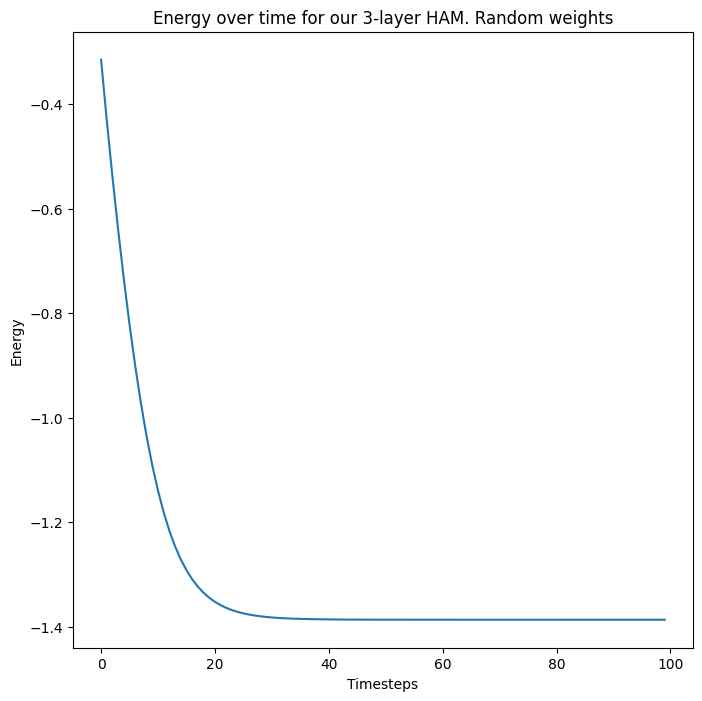

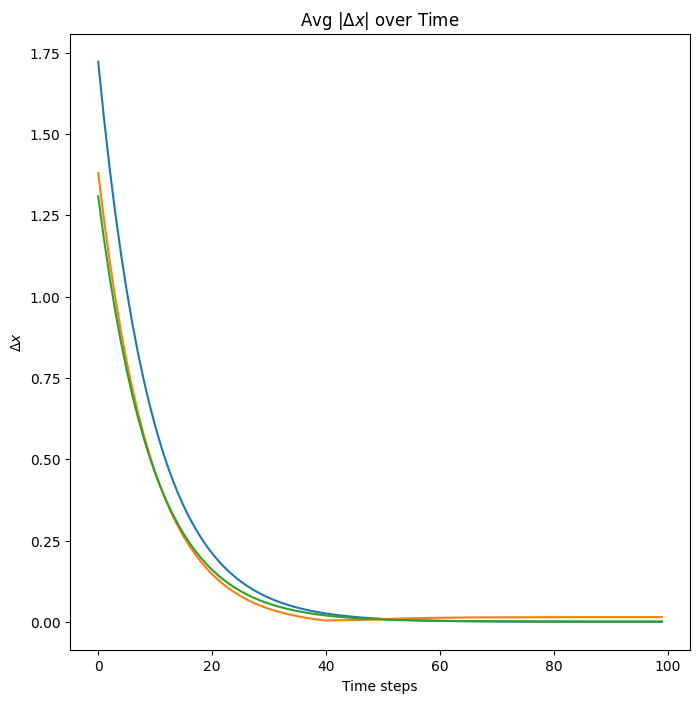

In [ ]:
#| code-fold: true
fig, ax = plt.subplots(1)
# ax = axs[0]
ax.plot(np.stack(energies))
ax.set_ylabel("Energy")
ax.set_xlabel("Timesteps")
ax.set_title("Energy over time for our 3-layer HAM. Random weights")
plt.show(fig)

x0diffs = jnp.abs(jnp.diff(jnp.stack([x[0] for x in allx]))).mean(-1)
x1diffs = jnp.abs(jnp.diff(jnp.stack([x[1] for x in allx]))).mean(-1)
x2diffs = jnp.abs(jnp.diff(jnp.stack([x[2] for x in allx]))).mean(-1)
# ax = axs[1]
fig2, ax = plt.subplots(1)
ax.plot(np.stack([x0diffs, x1diffs, x2diffs], axis=-1))
ax.set_title("Avg $|\Delta x|$ over Time")
ax.set_xlabel("Time steps")
ax.set_ylabel("$\Delta x$")

plt.show(fig)
plt.show(fig2)

So our 3-layer HAM system with randomly initialized weights and states converges to a fixed energy, at which point the states of each layer do not further change.

We implement the above, simple step function into the class, though more advanced optimizations from the JAX ecosystem (e.g., [optax](https://github.com/deepmind/optax)) can easily be used.

In [ ]:
#| export
@patch
def step(self:HAM,
    xs: List[jnp.ndarray], # Collection of current states for each layer
    updates: List[jnp.ndarray], # Collection of update directions for each state
    dt: float = 0.1, # Stepsize to take in direction of updates
    masks: Optional[List[jnp.ndarray]] = None, # Boolean mask, 0 if clamped neuron, and 1 elsewhere. A pytree identical to `xs`. Optional.
):
    """A discrete step down the energy using step size `dt` scaled by the `tau` of each layer"""
    taus = self.layer_taus
    alphas = [dt / tau for tau in taus] # Scaling factor of the update size of each layer
    if masks is not None:
        next_xs = jtu.tree_map(lambda x, u, m, alpha: x + alpha * u * m, xs, updates, masks, alphas)
    else:
        next_xs = jtu.tree_map(lambda x, u, alpha: x + alpha * u, xs, updates, alphas)
    return next_xs

It is particularly useful if all of these functions can be applied to a batched collection of states, something JAX makes particularly easy through its [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) functionality. We prefix vectorized versions of the above methods with a `v`.

In [ ]:
#| export
@patch
def _statelist_batch_axes(self:HAM):
    """A helper function to tell vmap to batch along the 0'th dimension of each state in the HAM."""
    return ([0 for _ in range(self.n_layers)],)
    
@patch
def vactivations(self:HAM, 
                 xs: List[jnp.ndarray]): # Collection of states for each layer
    """A vectorized version of `activations`"""
    return jax.vmap(self.activations, in_axes=self._statelist_batch_axes())(xs)

@patch
def venergy(self:HAM, 
            xs: List[jnp.ndarray]): # Collection of states for each layer
    """A vectorized version of `energy`"""
    return jax.vmap(self.energy, in_axes=self._statelist_batch_axes())(xs)

@patch
def vdEdg(self:HAM, 
          xs: List[jnp.ndarray]): # Collection of states for each layer
    """A vectorized version of `dEdg`"""
    return jax.vmap(self.dEdg, in_axes=self._statelist_batch_axes())(xs)

@patch
def vupdates(self:HAM,
             xs: List[jnp.ndarray]): # Collection of states for each layer
    """A vectorized version of `updates`"""
    return jax.vmap(self.updates, in_axes=self._statelist_batch_axes())(xs)

In [ ]:
batch_size=5
vxs = ham.init_states(bs=batch_size, rng=jax.random.PRNGKey(2))

In [ ]:
#| code-fold: true
print("\n".join([f"x{i}: {x.shape}" for i,x in enumerate(xs)])) # The dynamic variables

x0: (2,)
x1: (3,)
x2: (4,)


We repeat the above energy analysis for batched samples. For an untrained network, all samples achieve the same energy

In [ ]:
@jax.jit
def step(ham, xs, dt):
    energy = ham.venergy(xs)
    updates = ham.vupdates(xs)
    alphas = [dt / tau for tau in ham.layer_taus]
    next_states = jtu.tree_map(lambda x, u, alpha: x + alpha*u, xs, updates, alphas)
    return energy, next_states

energies = []; allx = []; dt = 0.03; x = vxs
for i in range(100):
    energy, x = step(ham, x, dt)
    energies.append(energy)
    allx.append(x)
    
senergies = jnp.stack(energies)

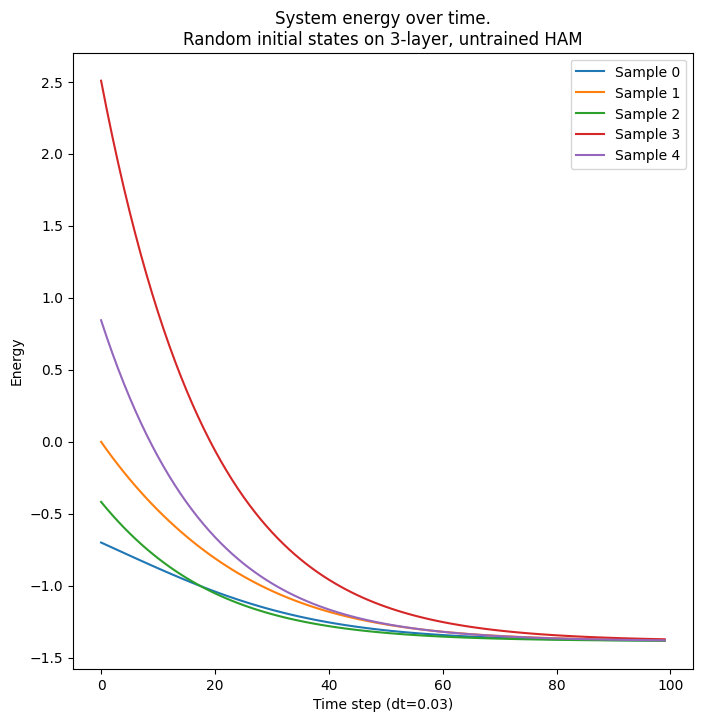

In [ ]:
#| code-fold: true
fig,ax = plt.subplots(1)
ax.plot(senergies)
ax.set_xlabel(f"Time step (dt={dt})")
ax.set_ylabel(f"Energy")
ax.set_title(f"System energy over time.\nRandom initial states on 3-layer, untrained HAM")
ax.legend([f"Sample {i}" for i in range(senergies.shape[-1])])
plt.show(fig)

We create several helper functions to save and load our state dict.

In [ ]:
#| export
@patch
def load_state_dict(self:HAM, 
                    state_dict:Any): # The dictionary of all parameters, saved by `save_state_dict`
    """Load the state dictionary for a HAM"""
    if not self.initialized:
        _, self = self.init_states_and_params(jax.random.PRNGKey(0), 1)
    self.connections = state_dict["connections"]
    self.layers = align_with_state_dict(self.layers, state_dict["layers"])
    self.synapses = align_with_state_dict(self.synapses, state_dict["synapses"])
    return self

@patch
def to_state_dict(self:HAM):
    """Convert HAM to state dictionary of parameters and connections"""
    return jtu.tree_map(to_pickleable, self.to_dict())

@patch
def save_state_dict(self:HAM, 
                    fname:Union[str, Path], # Filename of checkpoint to save
                    overwrite:bool=True): # Overwrite an existing file of the same name?
    """Save the state dictionary for a HAM"""
    to_save = self.to_state_dict()
    pytree_save(to_save, fname, overwrite=overwrite)

@patch
def load_ckpt(self:HAM, 
              ckpt_f:Union[str, Path]): # Filename of checkpoint to load
    """Load from file name"""
    with open(ckpt_f, "rb") as fp:
        state_dict = pickle.load(fp)
    return self.load_state_dict(state_dict)

### Visualizing a HAM

We employ the [`hypernetx`](https://github.com/pnnl/HyperNetX) package to create a simple visualization of the layers and nodes

In [ ]:
#| Export
@patch
def visualize(self:HAM):
    """Return a simple hypergraph object of the connections."""
    nodenames = [l.name for l in self.layers]
    edgenames = [s.name for s in self.synapses]
    graph = {f"{edgenames[syn_idx]} ({syn_idx})": [f"{nodenames[i]} ({i})" for i in layer_idxs] for layer_idxs, syn_idx in self.connections}
    H = hnetx.Hypergraph(graph, name=self.name)
    return H

## Example Model Architectures

We can use our primitive visualization function to see the connections of our model. We showcase these only to express what is possible to build using our architectures. Hierarchical models have not yet been tested

### Simple Hopfield Network

Consisting of one visible layer and one hidden layer

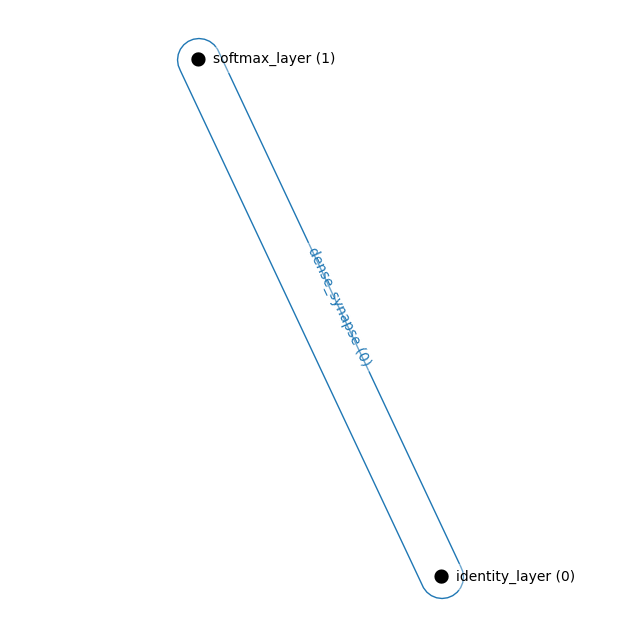

In [ ]:
layers = [
    IdentityLayer((768,)), # Visible Layer
    SoftmaxLayer((1000,)), # Hidden Layer
]
synapses = [
    DenseSynapse()
]
connections = [
    ((0,1),0)
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

### Simple Convolutional Layer

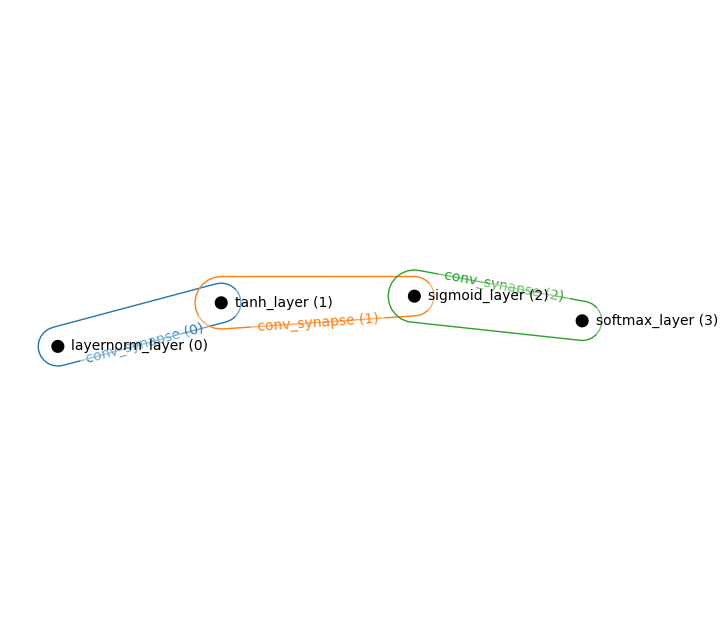

In [ ]:
layers = [
    LayerNormLayer((32,32,3)), # Visible Layer
    TanhLayer((16,16,128,)),
    SigmoidLayer((8,8,256)),
    SoftmaxLayer((4,4,256)),
]
synapses = [
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
]

connections = [
    ((0,1),0),
    ((1,2),1),
    ((2,3),2)
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

### Energy Transformer (explicit Hopfield Module)

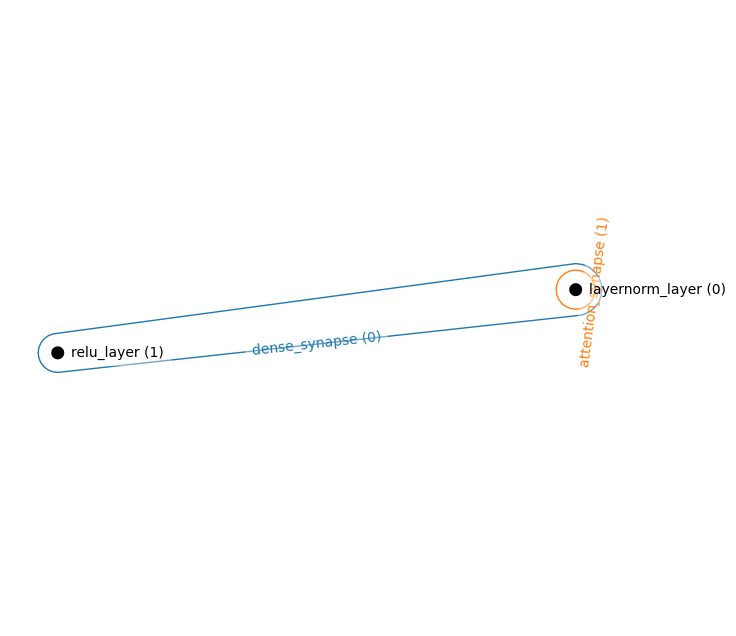

In [ ]:
layers = [
    LayerNormLayer((768,)), # Visible Layer
    ReluLayer((3072,)), # Hidden layer of CHN
]

synapses = [
    DenseSynapse(),
    AttentionSynapse(num_heads=3, zspace_dim=224)
]
connections = [
    ((0,1), 0),
    ((0,0), 1),
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

### Energy Transformer (implicit Hopfield Module)

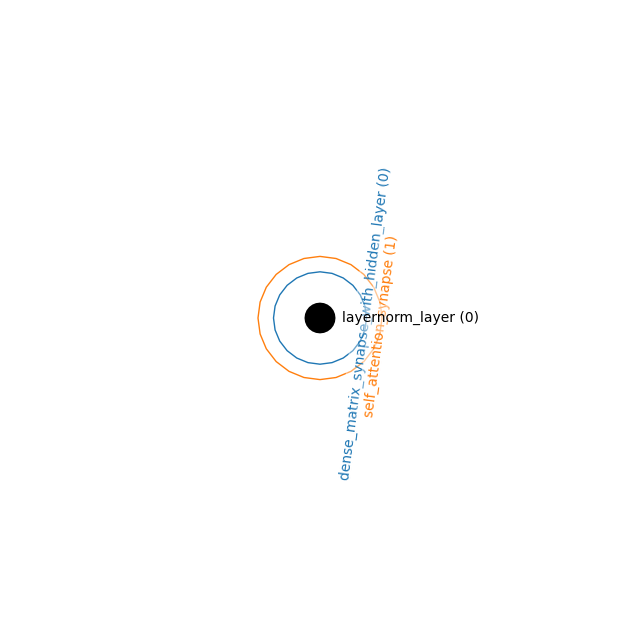

In [ ]:
layers = [
    LayerNormLayer((768,)), # Visible Layer
]

synapses = [
    DenseMatrixSynapseWithHiddenLayer(nhid=3072),
    SelfAttentionSynapse(num_heads=3, zspace_dim=224)
]
connections = [
    ((0,), 0),
    ((0,), 1),
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

### Attention and Convolutions

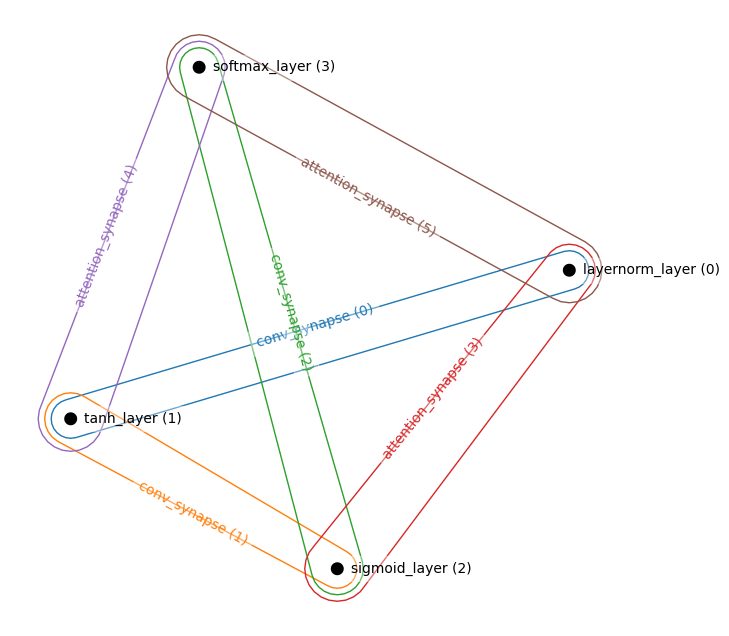

In [ ]:
layers = [
    LayerNormLayer((32,32,3)), # Visible Layer
    TanhLayer((16,16,128,)),
    SigmoidLayer((8,8,256)),
    SoftmaxLayer((4,4,256)),

]
synapses = [
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
    AttentionSynapse(num_heads=3, zspace_dim=64),
    AttentionSynapse(num_heads=3, zspace_dim=64),
    AttentionSynapse(num_heads=3, zspace_dim=64),
]

connections = [
    ((0,1),0),
    ((1,2),1),
    ((2,3),2),
    ((0,2),3),
    ((1,3),4),
    ((0,3),5),
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

### N-ary synapses

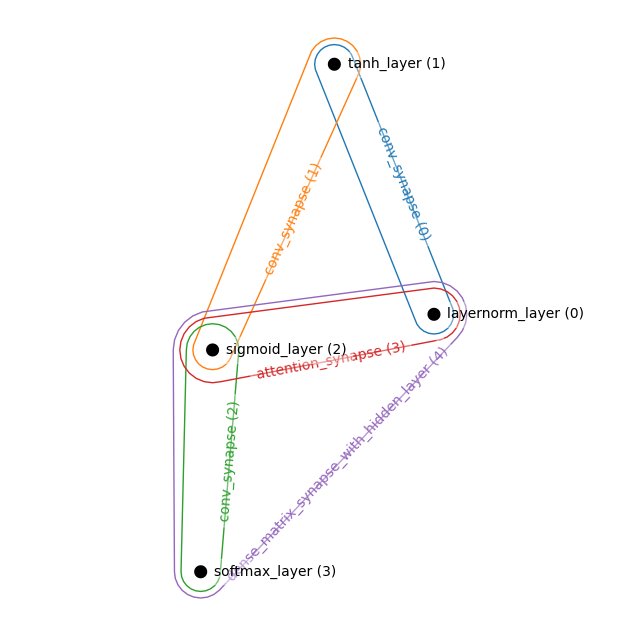

In [ ]:
layers = [
    LayerNormLayer((32,32,3)), # Visible Layer
    TanhLayer((16,16,128,)),
    SigmoidLayer((8,8,256)),
    SoftmaxLayer((4,4,256)),

]
synapses = [
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
    ConvSynapse((2,2), strides=(2,2)),
    AttentionSynapse(num_heads=3, zspace_dim=64),
    DenseMatrixSynapseWithHiddenLayer(200)
]

connections = [
    ((0,1),0),
    ((1,2),1),
    ((2,3),2),
    ((0,2),3),
    ((0,2,3),4)
]

ham = HAM(layers, synapses, connections)
_, ham = ham.init_states_and_params(jax.random.PRNGKey(0))
hnetx.draw(ham.visualize())

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()